In [1]:
cd /cellar/users/agross/TCGA_Code/Methlation/Benchmarks

/cellar/users/agross/TCGA_Code/Methlation/Benchmarks


/cellar/users/agross/anaconda2/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


importing IPython notebook from Model_Comparison_MF

importing IPython notebook from Age_Models_All_Patients

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


importing IPython notebook from Setup/MethylationAgeModels

importing IPython notebook from Setup/Read_HIV_Data

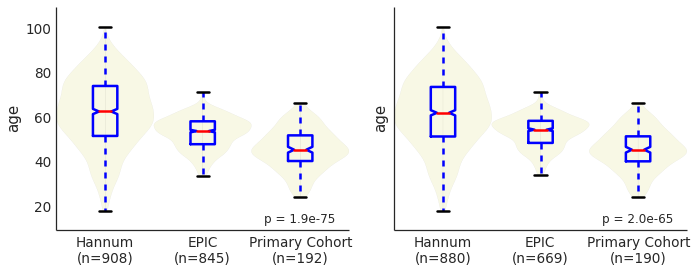

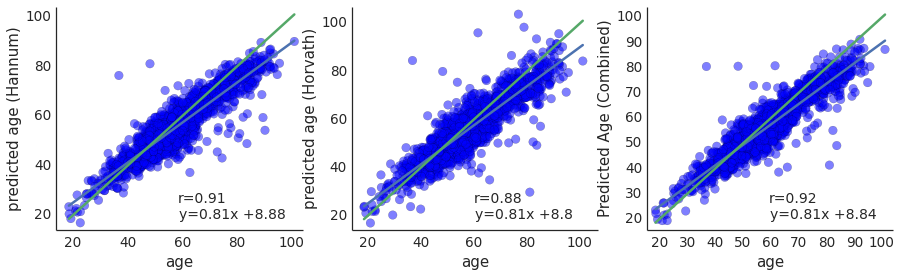

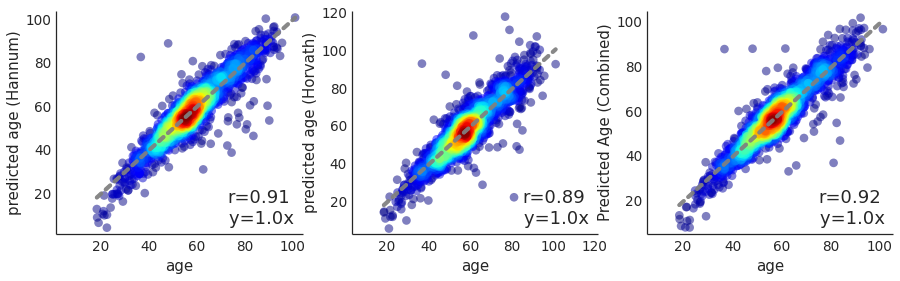

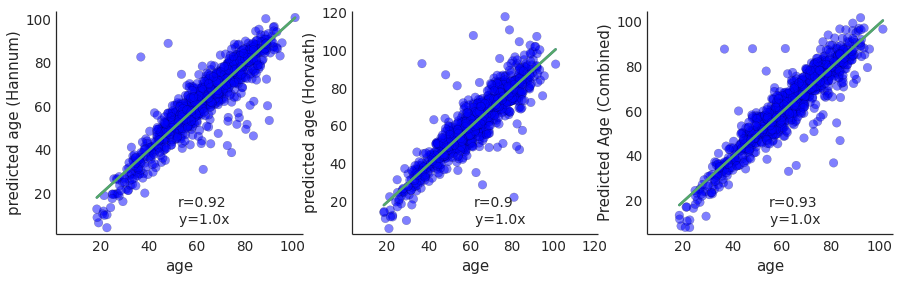

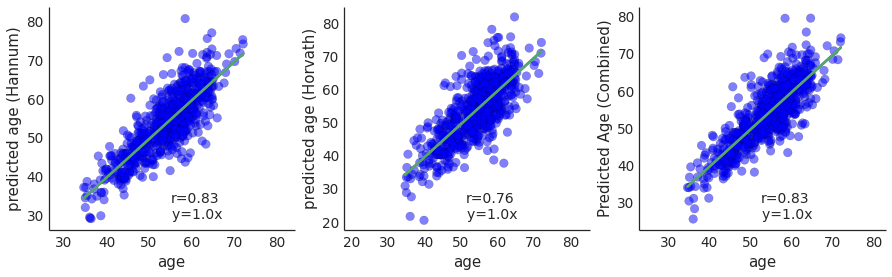

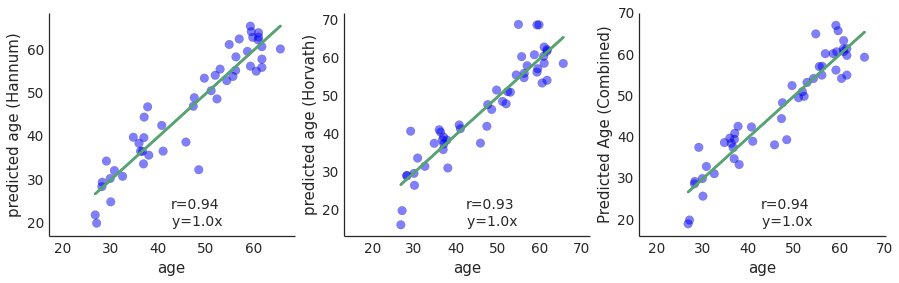

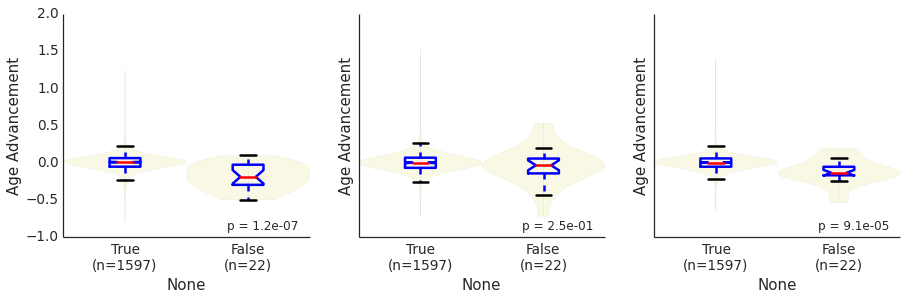

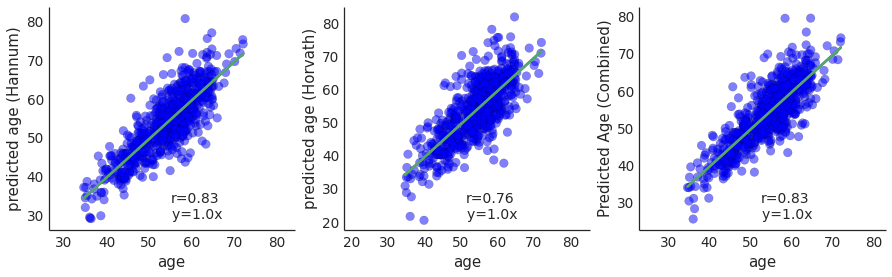

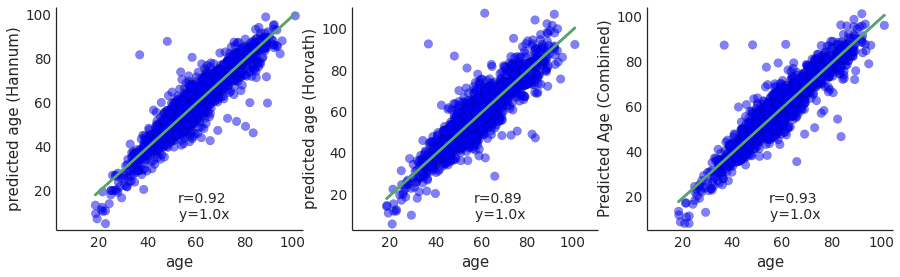

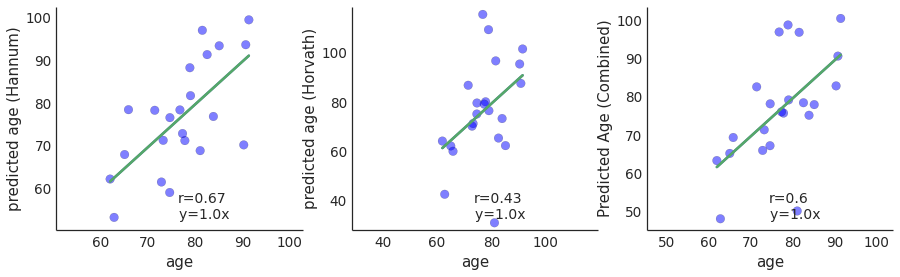

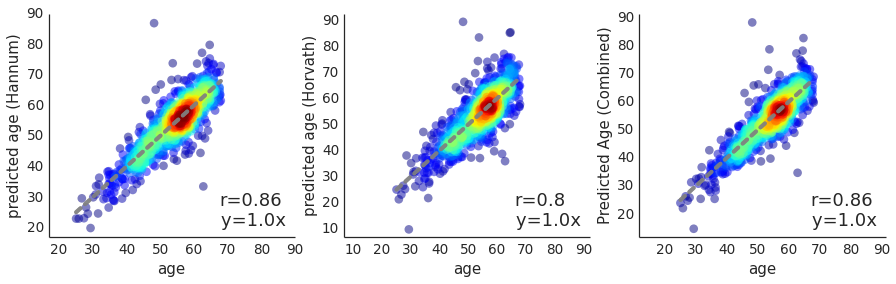

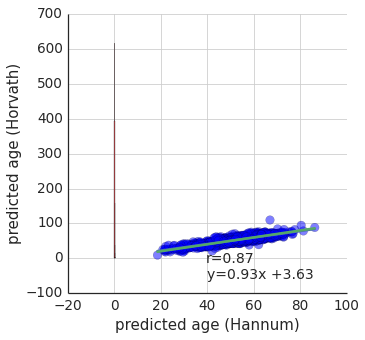

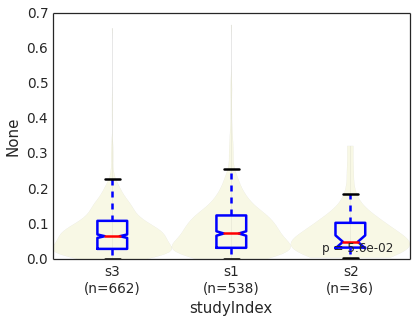

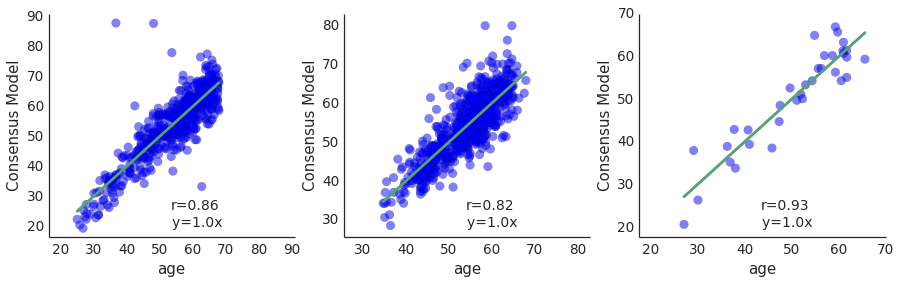

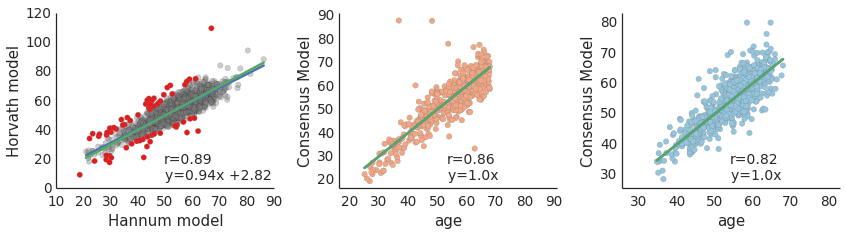

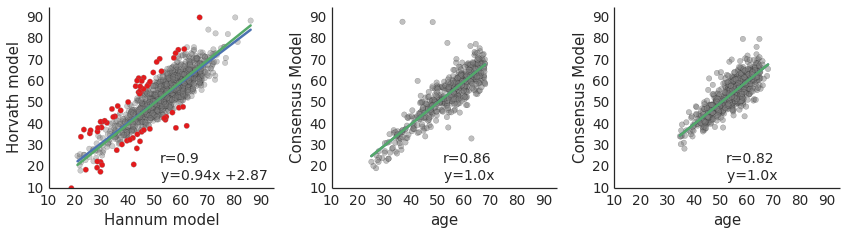

In [2]:
import NotebookImport
from Model_Comparison_MF import *

#### Logit Transform and Normalize Methylation Data

In [5]:
k = ti((age < 68) & (age > 25))

In [4]:
dd = logit_adj(df_meth.ix[:, k])
m = dd.mean(1)
s = dd.std(1)
df_norm = dd.subtract(m, axis=0).divide(s, axis=0)
df_norm = df_norm.clip(-7,7)

#### Prepare Data for Association Tests

* The association tests take a while to run in serial so we do them in a map-reduce type format  
* The idea is we break the data into 100 chunks, run the tests in parallel, and then combine the results  
* This is not entirely necissary but drops run-time from ~15 min to about 15 seconds

In [7]:
def chunkify_df(df, store, table_name, N=100):
    df = df.dropna(1)
    for i in range(N):
        g = df.index[i::N]
        dd = df.ix[g]
        dd.to_hdf(store, '{}/chunk_{}'.format(table_name, i))

In [8]:
gender.value_counts()

F    1148
M     801
dtype: int64

In [9]:
labels.ix[k.intersection(df_meth.columns)].value_counts()

s3    662
s1    538
s2    189
dtype: int64

In [8]:
store = '/cellar/users/agross/Data/tmp/for_parallel.h5'
store = pd.HDFStore(store)

store['labels'] = labels
store['bio_age'] = mc_adj_c
store['cell_counts'] = cell_counts
store['age'] = age
store['gender'] = gender == 'M'
#store['bio_age'] = age_adv.append(age_adv0)

/cellar/users/agross/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:2441: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->index] [items->None]

  warnings.warn(ws, PerformanceWarning)


In [9]:
labels.ix[k.intersection(df_meth.columns)].value_counts()

s3    662
s1    538
s2    189
dtype: int64

In [ ]:
chunkify_df(df_norm.ix[:, ti(labels == 's1')], store.filename, 'in_set_s1')
chunkify_df(df_norm.ix[:, ti(labels == 's2')], store.filename, 'in_set_s2')
chunkify_df(df_norm.ix[:, ti(labels == 's3')], store.filename, 'in_set_s3')

In [ ]:
store.close()
store.open()